In [1]:
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy

In [2]:
# main constants

# reference distance (meters)
d0 = 1 
# constant for particular propagation enviroment
k = 1e-4
# path loss exponent
n = 4
# total available bandwidth (Hz)
b_t = 100 * 1e6
# constant for noise power (W/Hz)
k_0 = 1e-20
# Side of total area (meters)
area_side = 1e3

In [3]:
def lin2db(x):
    return 10.0*np.log10(x)

def db2lin(x):
    return 10.0**(x/10.0)

def lin2dbm(x):
    return 10.0*np.log10(x)+30.0

def dbm2lin(x):
    return 10.0**(x/10.0 - 3.0)

In [4]:
def random_position():
    
    x_position = np.random.rand()*area_side
    y_position = np.random.rand()*area_side
    
    return [x_position, y_position]

def distance(UE_position, AP_position):

    distance_calculated =  np.linalg.norm(np.array(UE_position)
                                          - np.array(AP_position))

    return distance_calculated
    
def AP_position(AP_quantity):
    
    # Generates a list of coordenates according to the number of APs
    # in the simulation. It distributes the APs evenly.

    # Checks if the number of APs is a perfect square.
    if np.sqrt(AP_quantity).is_integer(): 

        AP_quantity_side = int(np.sqrt(AP_quantity))
    
        cell_side = area_side // AP_quantity_side
    
        # Creates coordenates using meshgrid.
        x, y = np.meshgrid(np.arange(0.5 * cell_side, 
                                     area_side, 
                                     cell_side),
                           np.arange(0.5 * cell_side, 
                                     area_side, 
                                     cell_side))
        
        APs_positions = np.column_stack((x.ravel(), y.ravel()))
    else:
        print("AP quantity must be a perfect square")

    return APs_positions

In [5]:
# Functions to calculate equations given by the base material

def calculate_received_power(transmitted_power, shadowing, distance):
    return transmitted_power * shadowing * (k / (distance**n))
    
def calculate_bandwidth_channel(total_bandwidth, channels_quantity):
    return total_bandwidth / channels_quantity

def calculate_noise_power(total_bandwidth, channels_quantity):
    return k_0 * calculate_bandwidth_channel(total_bandwidth, channels_quantity)

def calculate_SNR(user_power, noise_power):
    return user_power / noise_power

def calculate_SINR(user_power, interference_power, noise_power):
    return user_power / (interference_power + noise_power)

In [6]:
def eCDF(data):
    x = np.sort(data)
    y = np.arange(0, len(data)) / len(data)

    return x, y  

In [7]:
# Models the UEs
class UserEquipment:
    
    def __init__(self, transmitted_power_ = 1): # UE transmission power is 1 W by standard
        
        # Distance is sorted randomly in a 1000x1000m area 
        self.position = random_position()
        self.distance2AP = 0
        
        self.transmitted_power = transmitted_power_
        self.received_power = 0

        self.interfering_power = 0

In [8]:
# Models the APs
class AccessPoint:

    def __init__(self, channels_quantity_, position_ = [0, 0]):

        self.position = position_

        # Adds keys with a empty list for each channel in the system
        self.channels = dict()
        for m in range(channels_quantity_):
            self.channels[m + 1] = []

In [9]:
# CLass that plots the APs and UEs
class LinkSystem:

    '''
    for fractional power control, power_control = 0
    for max rate, power_control = 1
    '''
    def __init__(self, AP_quantity_, 
                       UE_quantity_, 
                       channels_quantity_,
                       power_control):

        self.AP_quantity = AP_quantity_
        self.AP_list = []
        
        self.UE_quantity = UE_quantity_
        self.UE_list = []
        
        self.channels_quantity = channels_quantity_

        self.noise_power = calculate_noise_power(b_t, 
                                                 self.channels_quantity)

        
        ''' Matrix of shadowing of each link, in which the rows are related to UEs
        and columns are related to APs '''
        self.shadowing_matrix = np.zeros((self.UE_quantity, 
                                          self.AP_quantity))
        
        for UE in range(self.UE_quantity):
            for AP in range(self.AP_quantity):
                self.shadowing_matrix[UE][AP] = np.random.lognormal(sigma=2.0)  

        
        ''' Add APs in system '''
        positions = AP_position(self.AP_quantity)
        index = 0
        
        for AP in range(self.AP_quantity):
            
            self.AP_list.append(AccessPoint(self.channels_quantity, 
                                            positions[index]))
            index += 1


        ''' add UEs to the system '''
        for UE in range(self.UE_quantity):
                self.UE_list.append(UserEquipment())  

        
        ''' Matrix of shadowing of each link, in which the rows are related to UEs
        and columns are related to APs '''
        self.gain_matrix = np.zeros((self.UE_quantity,
                                     self.AP_quantity))
        
        for UE in self.UE_list:
            for AP in self.AP_list:
                gain = ((self.shadowing_matrix[self.UE_list.index(UE)][self.AP_list.index(AP)]
                        * k) / distance(UE.position, AP.position))
                
                self.gain_matrix[self.UE_list.index(UE)][self.AP_list.index(AP)] = gain
                
        ''' Makes the power control '''
        if power_control == 0:

            max_power = 1 # Maximum achievable power in watts
            compensation_factor = 0.6 # Compensation factor as given by article (debatable)
            target_received_power = 2.950956e-04 # P_0 = 0.5 W
           
            self.power_list = []
       
            for i in range(self.UE_quantity):
                
                zeta = np.sqrt(sum(self.gain_matrix[i]))
                new_transmitted_power = (target_received_power 
                                         * pow(zeta, - compensation_factor)) 
                
                if new_transmitted_power < max_power:
                    self.power_list.append(new_transmitted_power)
                else:
                    self.power_list.append(max_power)
        
            for power in range(self.UE_quantity):
                    
                self.UE_list[power].transmitted_power = self.power_list[power]
                    
        elif power_control == 1:

            for power in range(self.UE_quantity):

                self.UE_list[power].transmitted_power = 1
        
        ''' Stores the linked AP from each UE according to channel
        and allocate them in this AP channels '''
        for UE in range(self.UE_quantity):

            linkedAP = 0
            min_gain = float('-inf')
            
            for AP in range(self.AP_quantity):
                if self.gain_matrix[UE][AP] > min_gain:
                    linkedAP = self.AP_list[AP]
                    min_gain = self.gain_matrix[UE][AP]
                
            
            ''' Uses the AP with better channel, that it stored in the loop above.
            Stores the better channel AP from each UE and allocate them in 
            this AP channels, calculating its distance to linked AP. '''

            if self.channels_quantity > 1:
                linkedAP.channels[np.random.randint(1, self.channels_quantity)].append(self.UE_list[UE])
            else:
                linkedAP.channels[1].append(self.UE_list[UE])

            if distance(self.UE_list[UE].position, 
                        linkedAP.position) < d0:
                self.UE_list[UE].distance2AP = distance(self.UE_list[UE].position, 
                                                    linkedAP.position)
            else:
                self.UE_list[UE].distance2AP = d0

        
        self.SNR_list = []
        self.SINR_list = []
        self.spectral_efficiency_list = []
            
        ''' It calculates each UE KPI for each AP channel '''
        for AP in self.AP_list:
                                
            for channel in AP.channels:
                
                # Power sum of all UEs in the channel
                power_sum = 0
                
                # Calculates the received power of each UE
                for UE in AP.channels[channel]:           
    
                    # Calculates the received power of each UE
                    UE.received_power = calculate_received_power(UE.transmitted_power, 
                                                                 self.shadowing_matrix[self.UE_list.index(UE)][self.AP_list.index(AP)],
                                                                 UE.distance2AP)
                    
                    power_sum += UE.received_power
                        
                    # Calculating SNR
                    for UE in AP.channels[channel]:
                        self.SNR_list.append(lin2db(calculate_SNR(UE.received_power, 
                                                                  self.noise_power)))
    
                    # Calculating SINR
                    for UE in AP.channels[channel]:
                        UE_used = UE.received_power
                        UE.interfering_power = power_sum - UE_used
                        
                        self.SINR_list.append(lin2db(UE_used 
                                                     / (UE.interfering_power 
                                                     + self.noise_power)))
    
                        # self.SINR_list[user_] = lin2db(calculate_SINR(UE_used, interfering_sum, noise_p))
                        # The function is not working for some reason I will take care later
                
                # Calculating Spectral Efficiency
                for user_SINR_ in range(len(self.SINR_list)):
                    bandwidth_ = calculate_bandwidth_channel(b_t, self.channels_quantity)
                    self.spectral_efficiency_list.append(np.log2(1 
                                                         + db2lin(self.SINR_list[user_SINR_])))


    

    def centralized_power_control(self):
        
        matrix_F = np.zeros((self.UE_quantity, self.AP_quantity))
        
        
        if self.UE_quantity < self.AP_quantity:
        
            for line in range(self.UE_quantity):
                matrix_F[line,:] = self.gain_matrix[line,:] / self.gain_matrix[line,line]
        
        else:
            
            direct_gain = np.zeros(self.AP_quantity)
            
            for column in range(self.AP_quantity):
                direct_gain[column] = self.gain_matrix[column,column]

            for line in range(self.UE_quantity):

                if line  < self.AP_quantity:
                  matrix_F[line,:] = self.gain_matrix[line,:] / direct_gain[line]

                else:
                    matrix_F[line,:] = self.gain_matrix[line,:]

        
        matrix_F[np.where(matrix_F==1)] = 0

        return matrix_F
            

In [10]:
# Simulation parameters

iteracoes = 1000 # The quantity of simulations
users_quantity = 16
AP_quantity = 4
channels_quantity = 1

In [11]:
total_SNR = []
total_SINR = []
total_spectral_efficiency = []


for inter in range(iteracoes):
    
    # Creates many Users at once
    system = LinkSystem(AP_quantity, 
                        users_quantity, 
                        channels_quantity,
                        1)
        
    # The SNR, SINR and spectral efficiency of users    
    total_SNR = np.concatenate((total_SNR, 
                                system.SNR_list))
    
    total_SINR = np.concatenate((total_SINR, 
                                 system.SINR_list))
    
    total_spectral_efficiency = np.concatenate((total_spectral_efficiency, 
                                                system.spectral_efficiency_list))

/tmp/ipykernel_16732/630489032.py:2: RuntimeWarning: divide by zero encountered in log10
  return 10.0*np.log10(x)


In [12]:
total_SNR_ = []
total_SINR_ = []
total_spectral_efficiency_ = []


for inter in range(iteracoes):
    
    # Creates many Users at once
    system_ = LinkSystem(AP_quantity, 
                         users_quantity, 
                         channels_quantity,
                         0)
        
    # The SNR, SINR and spectral efficiency of users    
    total_SNR_ = np.concatenate((total_SNR_, 
                                system_.SNR_list))
    
    total_SINR_ = np.concatenate((total_SINR_, 
                                 system_.SINR_list))
    
    total_spectral_efficiency_ = np.concatenate((total_spectral_efficiency_, 
                                               2.950956e-04  system_.spectral_efficiency_list))

/tmp/ipykernel_16732/630489032.py:2: RuntimeWarning: divide by zero encountered in log10
  return 10.0*np.log10(x)


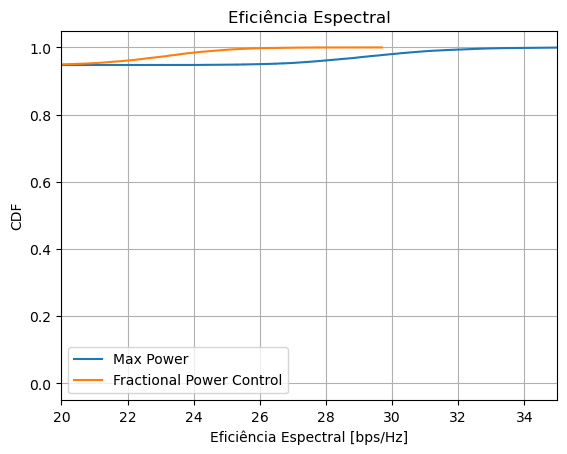

In [15]:
spectral_efficiencyCDF = eCDF(total_spectral_efficiency)
SINR_CDF = eCDF(total_SINR)
SNR_CDF = eCDF(total_SNR)

spectral_efficiencyCDF_ = eCDF(total_spectral_efficiency_)
SINR_CDF_ = eCDF(total_SINR_)
SNR_CDF_ = eCDF(total_SNR_)

plt.title('Eficiência Espectral')
plt.xlabel('Eficiência Espectral [bps/Hz]')
plt.ylabel('CDF')

# plt.ylim(0.0, 1.0)
plt.xlim(20, 35)
plt.plot(spectral_efficiencyCDF[0], spectral_efficiencyCDF[1], label = 'Max Power')
plt.plot(spectral_efficiencyCDF_[0], spectral_efficiencyCDF_[1], label = 'Fractional Power Control')
plt.legend()
plt.grid()

In [14]:
# spectral_efficiencyCDF = eCDF(b_t*total_spectral_efficiency)
# SINR_CDF = eCDF(total_SINR)
# SNR_CDF = eCDF(total_SNR)

# plt.title('Capacidade de canal (FPC)')
# plt.xlabel('Capacidade [bps]')
# plt.ylabel('CDF')

# plt.ylim(0.0, 1.0)
# plt.plot(spectral_efficiencyCDF[0], spectral_efficiencyCDF[1])
# plt.grid()